In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2025-04-23 17:36:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  23.8MB/s    in 8.1s    

2025-04-23 17:36:22 (19.9 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [3]:
from zipfile import ZipFile
with ZipFile('10_food_classes_10_percent.zip', 'r') as myzip:
    myzip.extractall()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pathlib
import PIL
import datetime


# keras_version = tf.keras.__version__

# if keras_version.split('.')[0] == '3': # Resolve compatibility issue between Keras and TensorflowHub
#     import tf_keras as keras
# else:
#     keras = tf.keras

In [5]:
data_dir = "10_food_classes_10_percent"
for dirpath,dirname,filenames in  os.walk(data_dir):
  print(f"There are {dirname} directories and {len(filenames)} images in '{dirpath}'.")

There are ['train', 'test'] directories and 0 images in '10_food_classes_10_percent'.
There are ['pizza', 'chicken_wings', 'ramen', 'grilled_salmon', 'hamburger', 'ice_cream', 'sushi', 'steak', 'chicken_curry', 'fried_rice'] directories and 0 images in '10_food_classes_10_percent/train'.
There are [] directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are [] directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are [] directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are [] directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are [] directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are [] directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are [] directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are [] directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are [] d

In [6]:
data_dir = pathlib.Path(data_dir).with_suffix('')
data_dir
image_count = len(list(data_dir.glob('*/*/*.jpg')))
train_image_count =len(list(data_dir.glob("train/*/*.jpg")))
test_image_count = len(list(data_dir.glob("test/*/*.jpg")))
print("Total Images",image_count)
print(f"Train Images {train_image_count}")
print(f"Test Images {test_image_count}")


Total Images 3250
Train Images 750
Test Images 2500


In [7]:
# dataset to load using the tf.keras.utils.image_dataset

BATCH_SIZE = 32
img_height = 224
img_width = 224
IMAGE_SIZE = (img_height,img_width)

train_data_dir = str(data_dir / "train")
test_data_dir =  str(data_dir / "test")

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  seed=123,
  # label_mode='categorical', for one_hot_encode
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  seed=123,
)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [9]:
class_names = train_ds.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

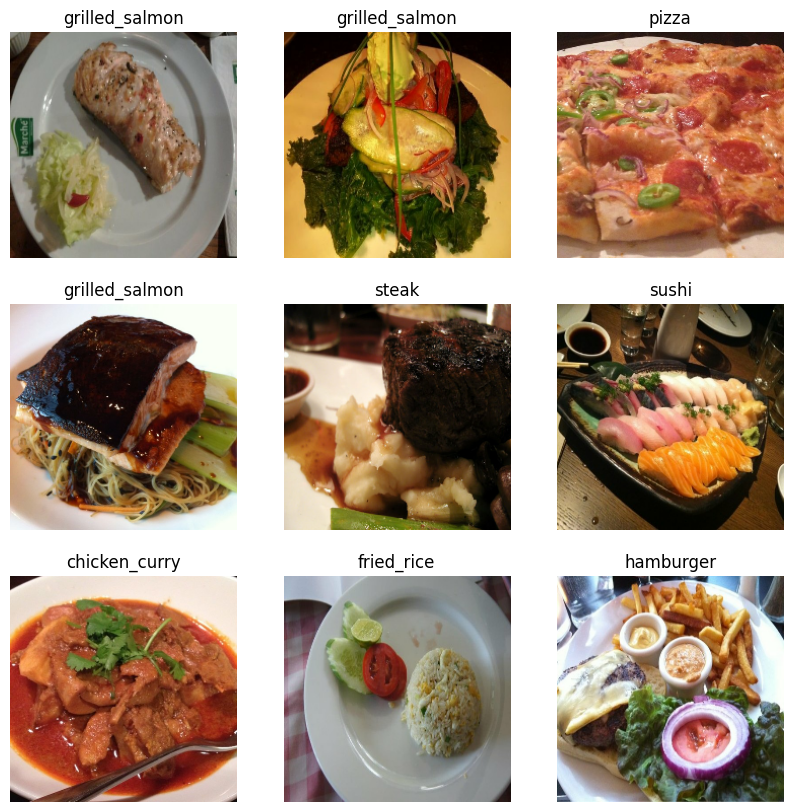

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Transfer Learning & Fine Tuning

In [11]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = f"{dir_name}/{experiment_name}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print("Saved tensorboard log files to",log_dir)
  return tensorboard_callback

In [12]:
# create base model using tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False,input_shape=IMAGE_SIZE + (3,))

# freeze the base model
base_model.trainable = False
# we have freeze our model now we have to add the top head of the model to make  the classifcation on 10 images

# create a new model on top
input_layer = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = base_model(input_layer)
print(f"Shape of the base model {x.shape}")
x = tf.keras.layers.GlobalAveragePooling2D()(x)
print(f"Shape of the model after appling the global average pooling {x.shape}")
output_layer = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)
model_0 = tf.keras.Model(input_layer, output_layer)
model_0.summary()



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape of the base model (None, 7, 7, 1280)
Shape of the model after appling the global average pooling (None, 1280)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
model_0.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # we used this loss function when our label are not in one_hot_encoded
    optimizer = tf.keras.optimizers.Adam(), # adam optimizer
    metrics = ['accuracy'] # accuracy to check the performance of the model on the traning and validataion dataset
)
# fit of the train data set on the model
model_0_history = model_0.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_steps=int(0.25 * len(test_ds)),
    callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="model_0")]
)

Saved tensorboard log files to model_logs/model_0/20250423-173636
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 747ms/step - accuracy: 0.2349 - loss: 2.1122 - val_accuracy: 0.7434 - val_loss: 1.2643
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7329 - loss: 1.1614 - val_accuracy: 0.8421 - val_loss: 0.8270
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.8084 - loss: 0.8249 - val_accuracy: 0.8684 - val_loss: 0.6567
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8306 - loss: 0.7095 - val_accuracy: 0.8783 - val_loss: 0.5424
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.8728 - loss: 0.5672 - val_accuracy: 0.8750 - val_loss: 0.5236


In [14]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

In [15]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
# layer of base_model (efficientNet-B0)
for layernum, layer in enumerate(base_model.layers):
  print(layernum, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [17]:
def loss_and_accuracy_plot(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()



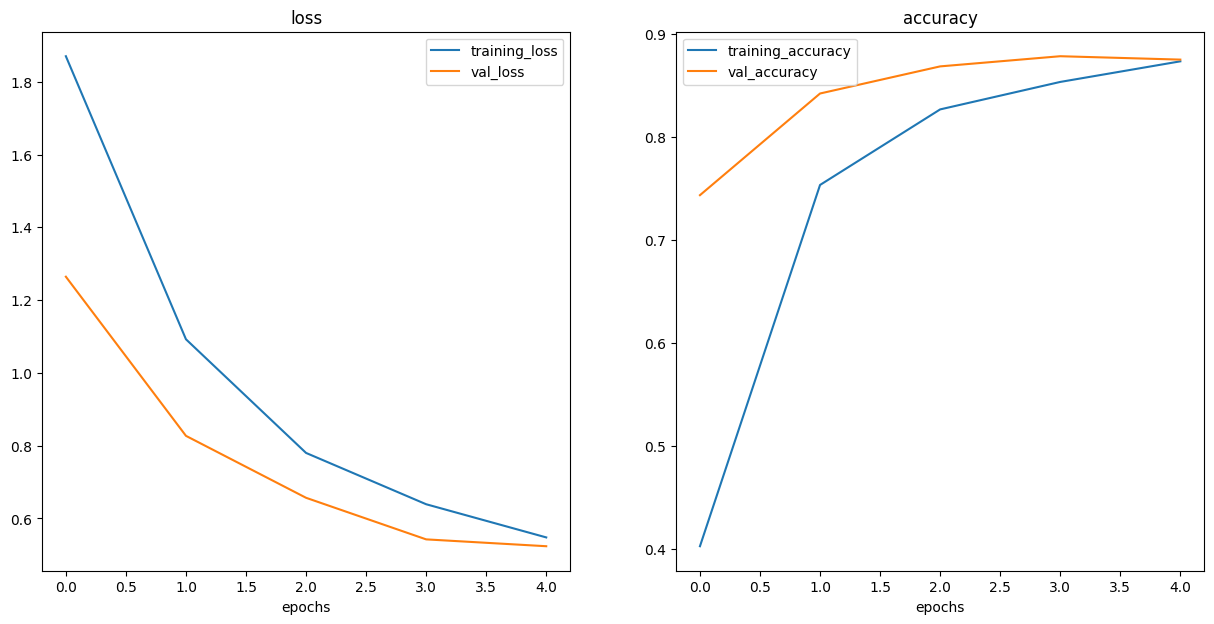

In [18]:
loss_and_accuracy_plot(model_0_history)


In [19]:
model_0.evaluate(test_ds) # check accuracy on test data

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8704 - loss: 0.5257


[0.5584696531295776, 0.8555999994277954]

## Global Average Pooling (GAP):
**Global Average Pooling (GAP) is a technique used in convolutional neural networks (CNNs) that replaces fully connected layers, particularly in the final classification stage. Instead of flattening the feature maps and feeding them into fully connected layers, GAP calculates the average of all values within each feature map, resulting in a single value per feature map. This effectively reduces the spatial dimensions of the feature maps to 1x1, leading to a vector representing the averaged activations across each feature map**

In [21]:
input_shape = (32,7,7,1280)

input_tensor = tf.random.normal(input_shape)
y = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(y)


tf.Tensor(
[[2.4648602 1.8684405 3.145287  ... 2.7955294 2.2149534 2.320255 ]
 [1.9412899 1.4616802 1.6815419 ... 2.0706744 2.1963627 1.3681883]
 [2.723702  2.3063214 2.0988524 ... 2.3482537 2.0709043 2.4010913]
 ...
 [2.7488375 2.0336    2.2967205 ... 2.3586173 2.5716143 2.4034095]
 [1.8585892 2.175654  1.961582  ... 2.7857368 3.4390523 2.3829956]
 [2.5054836 2.2871559 2.46165   ... 1.6130465 2.5295463 2.5022864]], shape=(32, 1280), dtype=float32)


In [22]:
# GlobalAveragePooling2D is used to take the average and the GlobalMaxPooling2D take the max value to get the important feature of the image

## Running Series Of Transfer Learning Experiments
+ `Model_1` - Using feature extraction transfer learning with 1% of training data and data augmentation

+ `Model_2` - Using feature extraction tranfer learning with 10% of training data and data augmentation

+ `Model_3` - Using Fine-tuning transfer learning with 10% of training data and data augmentation

+ `Model_4` - Using Fine-tuning  transfer learning with 100% of training data with data augmentation



In [23]:
model_one_base = tf.keras.applications.EfficientNetB0(include_top=False,input_shape=IMAGE_SIZE + (3,))
model_one_base.trainable = False
input_layer = tf.keras.Input(shape=IMAGE_SIZE + (3,))
# dataaugmentation
x=tf.keras.layers.RandomFlip()(input_layer)
x=tf.keras.layers.RandomRotation(0.2)(x)
x=tf.keras.layers.RandomZoom(0.2)(x)

x = model_one_base(input_layer)
print(x.shape)
x= tf.keras.layers.GlobalAveragePooling2D()(x) # this function is used to take the avearage and make the size of the tensor in equal to channel
print(x.shape)
output_layer = tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model_one = tf.keras.Model(input_layer, output_layer)

(None, 7, 7, 1280)
(None, 1280)


In [24]:
model_one.summary()
# we used summary to check the summary of the model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [25]:
model_one.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # we used this loss function when our label are not in one_hot_encoded
    optimizer = tf.keras.optimizers.Adam(), # adam optimizer
    metrics = ['accuracy'] # accuracy to check the performance of the model on the traning and validataion dataset
)


model_one_history = model_one.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_steps=int(0.25 * len(test_ds)),
    callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="model_1")]
  )

Saved tensorboard log files to model_logs/model_1/20250423-173755
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 681ms/step - accuracy: 0.2740 - loss: 2.1087 - val_accuracy: 0.7336 - val_loss: 1.2772
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.7682 - loss: 1.1823 - val_accuracy: 0.8191 - val_loss: 0.8323
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8105 - loss: 0.8686 - val_accuracy: 0.8520 - val_loss: 0.6654
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.8551 - loss: 0.6836 - val_accuracy: 0.8618 - val_loss: 0.5783
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8731 - loss: 0.5782 - val_accuracy: 0.8684 - val_loss: 0.5257


#   Model on 1% of the data of the food


In [26]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2025-04-23 17:38:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.6MB/s    in 6.7s    

2025-04-23 17:38:56 (19.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [27]:
from zipfile import ZipFile
with ZipFile('10_food_classes_1_percent.zip', 'r') as myzip:
    myzip.extractall()

In [28]:
data_dir = "10_food_classes_1_percent"
for dirpath,dirname,filenames in  os.walk(data_dir):
  print(f"There are {dirname} directories and {len(filenames)} images in '{dirpath}'.")

There are ['train', 'test'] directories and 0 images in '10_food_classes_1_percent'.
There are ['pizza', 'chicken_wings', 'ramen', 'grilled_salmon', 'hamburger', 'ice_cream', 'sushi', 'steak', 'chicken_curry', 'fried_rice'] directories and 0 images in '10_food_classes_1_percent/train'.
There are [] directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are [] directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are [] directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are [] directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are [] directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are [] directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are [] directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are [] directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are [] directories and 7 i

In [29]:
data_dir = pathlib.Path(data_dir).with_suffix('')
train_data_dir = str(data_dir / "train")
test_data_dir =  str(data_dir / "test")

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  seed=123,
  # label_mode='categorical', for one_hot_encode
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  seed=123,
)



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
# data augmentation layer

data_augmentation = tf.keras.Sequential(
    [
      tf.keras.layers.RandomFlip(),
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.2)
    ]
)

# this layer is used to make the images augmenation to the model so that the model get more data and diversity introduce in the model
# efficientnet mode
model_one_base = tf.keras.applications.EfficientNetB0(include_top=False,input_shape=IMAGE_SIZE + (3,))
model_one_base.trainable = False # freeze the training parameters
# input shape of the model
input_layer = tf.keras.Input(shape=IMAGE_SIZE + (3,))



# Data Augmentation
x=data_augmentation(input_layer)
x = model_one_base(x)
print(x.shape)
x= tf.keras.layers.GlobalAveragePooling2D()(x) # this function is used to take the avearage and make the size of the tensor in equal to channel
print(x.shape)
output_layer = tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model_one = tf.keras.Model(input_layer, output_layer)

(None, 7, 7, 1280)
(None, 1280)


In [31]:
model_one.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # we used this loss function when our label are not in one_hot_encoded
    optimizer = tf.keras.optimizers.Adam(), # adam optimizer
    metrics = ['accuracy'] # accuracy to check the performance of the model on the traning and validataion dataset
)

model_one_history = model_one.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_steps=int(0.25 * len(test_ds)),
    callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="model_1")]
  )

Saved tensorboard log files to model_logs/model_1/20250423-173859
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.0812 - loss: 2.3686 - val_accuracy: 0.2056 - val_loss: 2.1716
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.1853 - loss: 2.1762 - val_accuracy: 0.2928 - val_loss: 2.0578
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step - accuracy: 0.4174 - loss: 1.9024 - val_accuracy: 0.3750 - val_loss: 1.9471
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 952ms/step - accuracy: 0.5046 - loss: 1.7563 - val_accuracy: 0.4572 - val_loss: 1.8504
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 698ms/step - accuracy: 0.6125 - loss: 1.6679 - val_accuracy: 0.4655 - val_loss: 1.7862


In [32]:
model_one.evaluate(test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.4840 - loss: 1.7862


[1.7997643947601318, 0.47839999198913574]

## Data Augmenation Of The Images

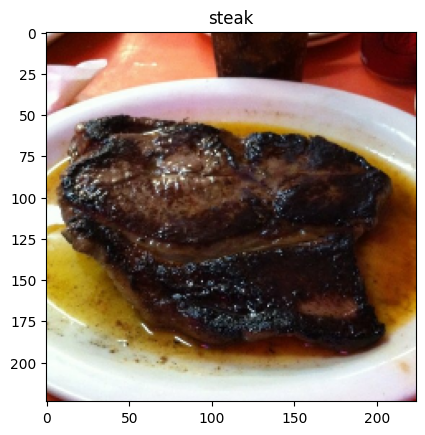

In [33]:
for image,label in train_ds.take(1):
  plt.imshow(image[0].numpy().astype('uint8'))
  plt.title(class_names[label[0]])
  plt.show()


  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  #  tf.keras.layers.Rescaling(1./255)
  ])



## Model_2 train on 10% dataset and data augmentation

In [34]:
# now we have to used the data augumentation on the image to make the model
data_dir = "10_food_classes_10_percent"
data_dir = pathlib.Path(data_dir).with_suffix('')
train_data_dir = str(data_dir / "train")
test_data_dir =  str(data_dir / "test")

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  seed=123,
  # label_mode='categorical', for one_hot_encode
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  seed=123,
)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
# data augmentation layer

data_augmentation = tf.keras.Sequential(
    [
      tf.keras.layers.RandomFlip(),
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.2)
    ],
    name="data_augmentation"
)

model_two_base = tf.keras.applications.EfficientNetB0(include_top=False,input_shape=IMAGE_SIZE + (3,))
model_two_base.trainable = False # freeze the training parameters
input_layer = tf.keras.Input(shape=IMAGE_SIZE + (3,))


# Data Augmentation
x=data_augmentation(input_layer)
x = model_two_base(x, training=False)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
output_layer = tf.keras.layers.Dense(10,activation="softmax")(x)
model_two= tf.keras.Model(input_layer, output_layer)

In [36]:
model_two.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # we used this loss function when our label are not in one_hot_encoded
    optimizer = tf.keras.optimizers.Adam(), # adam optimizer
    metrics = ['accuracy'] # accuracy to check the performance of the model on the traning and validataion dataset
)



In [37]:
model_two.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Create A ModelCheckPoint Callback
Modelcheckpoint callback is used to save the model or weight at some frequence of time like after each epoch so the model later start from the state which the model or weight are save

In [38]:
from tensorflow.keras.callbacks import Callback


# this callback save the model on each epoch based on the val_accuracy have max val_accuracy
checkpoint_filepath = 'checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
    )
# we have to save the  model weights only




In [39]:
model_two_history = model_two.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_steps=int(0.25 * len(test_ds)),
    callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="model_2"),model_checkpoint_callback],


  )


Saved tensorboard log files to model_logs/model_2/20250423-173933
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1729 - loss: 2.2535
Epoch 1: val_accuracy improved from -inf to 0.66447, saving model to checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - accuracy: 0.1776 - loss: 2.2459 - val_accuracy: 0.6645 - val_loss: 1.5168
Epoch 2/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5876 - loss: 1.5344
Epoch 2: val_accuracy improved from 0.66447 to 0.80592, saving model to checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.5895 - loss: 1.5266 - val_accuracy: 0.8059 - val_loss: 1.0455
Epoch 3/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7170 - loss: 1.1548
Epoch 3: val_accuracy improved from 0.80592 to 0.82237, saving model to checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.7163 - loss: 1.1533 - val_accuracy: 0.8224 - val_loss: 0.8425
Epoch 4/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step -

In [40]:
# for image,label in train_ds.take(1):
#   plt.imshow(image[0].numpy().astype('uint8'))
#   plt.title(class_names[label[0]])
#   plt.show()
model_two.evaluate(test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8463 - loss: 0.6424


[0.675070583820343, 0.8339999914169312]

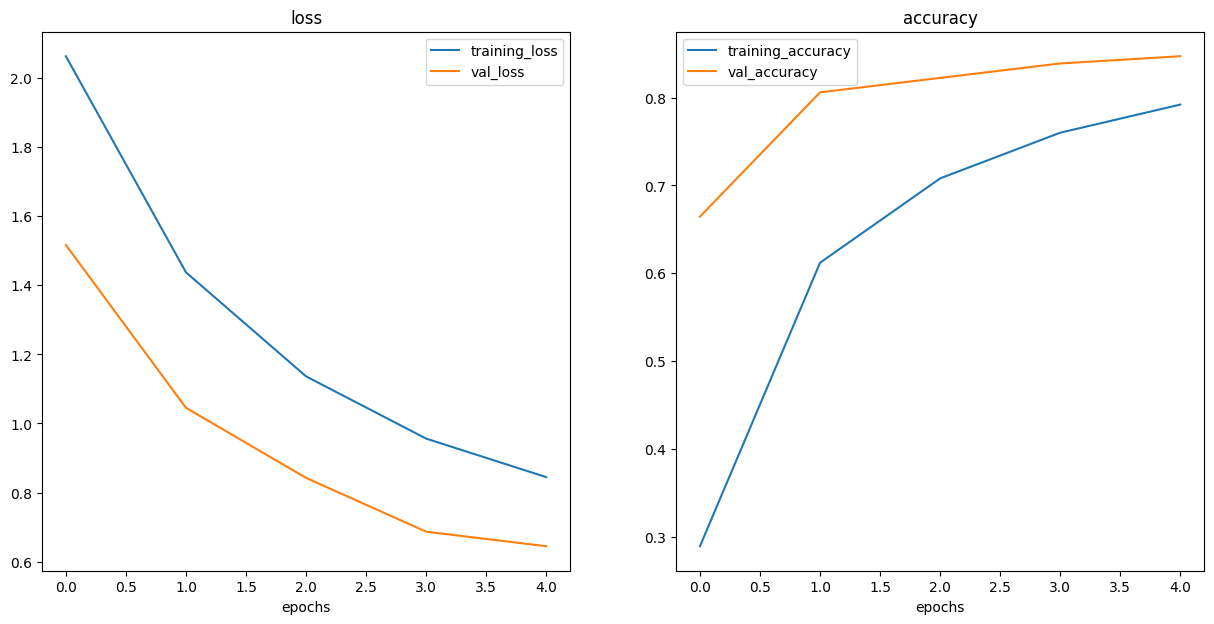

In [41]:
loss_and_accuracy_plot(model_two_history)

In [42]:
# The model weights (that are considered the best) can be loaded as -
model_two_before_weight_load =model_two.evaluate(test_ds)
model_two.load_weights(checkpoint_filepath)


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8425 - loss: 0.6456


In [43]:
model_two.evaluate(test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8322 - loss: 0.6643


[0.6750704646110535, 0.8339999914169312]

In [44]:
model_two_before_weight_load == model_two.evaluate(test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8316 - loss: 0.6631


True

In [45]:
import numpy as np

np.isclose(model_two_before_weight_load,model_two_before_weight_load)

array([ True,  True])

## Model 3: Fine-Tuning an Existing model on 10% Of The Data
***Note:***  Fine-Tuning Work best after training a feature extraction model for a few epochs with a custom data.

In [46]:
model_two.layers

[<InputLayer name=input_layer_8, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling, built=True>,
 <Dense name=dense_3, built=True>]

In [47]:
# how many layer are trainable?
for layer in model_two.layers:
    print(layer.name,layer.trainable)

input_layer_8 True
data_augmentation True
efficientnetb0 False
global_average_pooling True
dense_3 True


In [48]:
for i,layer in enumerate(model_two.layers[2].layers):
    print(layer.name, layer.trainable)

input_layer_7 False
rescaling_6 False
normalization_3 False
rescaling_7 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
bl

In [49]:
# how many tainable varaible in our base model and model_two
print("trainable variable in  model:", len(model_two.trainable_variables))
print("trainable variable in model_two_base:", len(model_two_base.trainable_variables))

trainable variable in  model: 2
trainable variable in model_two_base: 0


## Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable.
Then, you should recompile the model (necessary for these changes to take effect), and resume training.


Compile the model
As you are training a much larger model and want to readapt the pretrained weights,
it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [50]:
model_two_base.trainable = True
for layer in model_two_base.layers[:-10]:
    layer.trainable=False

learning_rate = 0.001/10
model_two.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # we used this loss function when our label are not in one_hot_encoded
    optimizer = tf.keras.optimizers.Adam(learning_rate), # adam optimizer learning_rate/10
    metrics = ['accuracy'] # accuracy to check the performance of the model on the traning and validataion dataset
)



In [51]:
for layer in model_two_base.layers:
    print(layer.name,layer.trainable)

input_layer_7 False
rescaling_6 False
normalization_3 False
rescaling_7 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
bl

In [52]:
print("trainable variable in  model:", len(model_two.trainable_variables))
print("trainable variable in base model:", len(model_two_base.trainable_variables))

trainable variable in  model: 12
trainable variable in base model: 10


In [53]:
len(model_two_history.epoch)

5

## Continue training the model
If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.


In [54]:
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fintuning = model_two.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch = len(model_two_history.epoch),
    validation_data=test_ds,
    validation_steps=int(0.25 * len(test_ds)),
    callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="tranferlearning")],

)


Saved tensorboard log files to model_logs/tranferlearning/20250423-174046
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.7441 - loss: 0.9469 - val_accuracy: 0.8388 - val_loss: 0.5720
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.8030 - loss: 0.7794 - val_accuracy: 0.8668 - val_loss: 0.5027
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.8562 - loss: 0.6702 - val_accuracy: 0.8569 - val_loss: 0.4779
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.8381 - loss: 0.6623 - val_accuracy: 0.8569 - val_loss: 0.4574
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.8473 - loss: 0.5968 - val_accuracy: 0.8717 - val_loss: 0.4160


In [55]:
model_two.evaluate(test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8584 - loss: 0.4626


[0.47067537903785706, 0.8519999980926514]

In [56]:
# before fine tuning
model_two_before_weight_load

[0.6750704646110535, 0.8339999914169312]

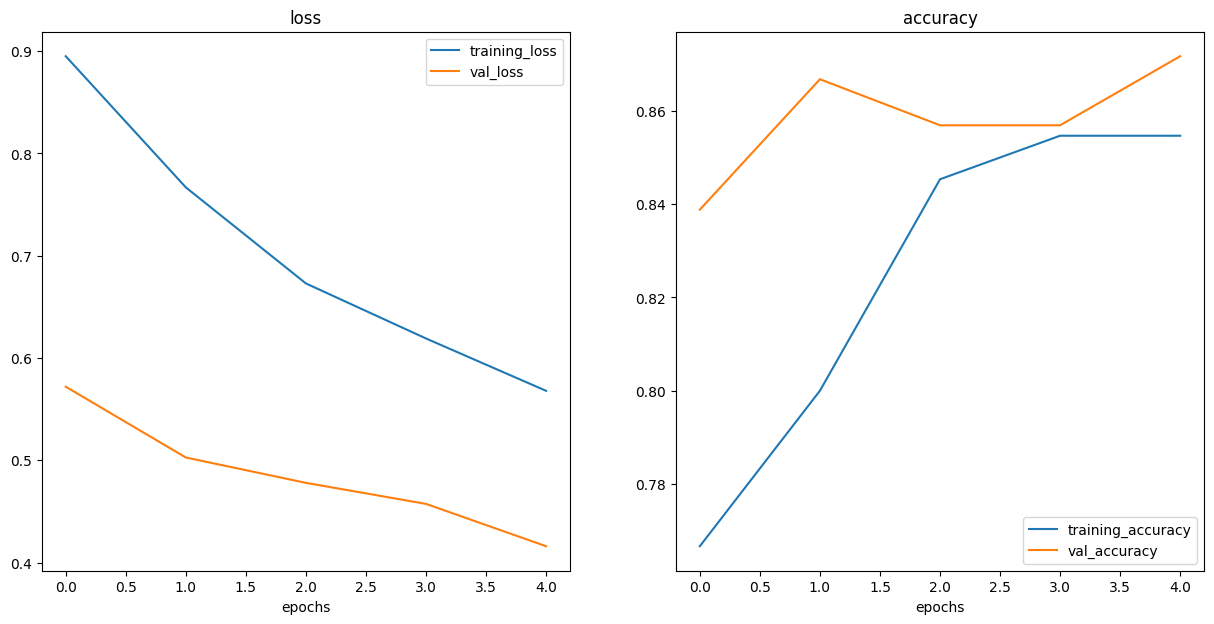

In [57]:
loss_and_accuracy_plot(history_fintuning)

## Comparing History Of training feature extractors   and fine tuning


In [58]:
def compare_history(feature_extractors_history, fine_tuning_history, initial_epoch = 5):

    acc = feature_extractors_history.history['accuracy']
    loss = feature_extractors_history.history['loss']


    val_acc = feature_extractors_history.history['val_accuracy']
    val_loss = feature_extractors_history.history['val_loss']

    total_acc = acc +  fine_tuning_history.history['accuracy']
    total_loss = loss + fine_tuning_history.history['loss']


    total_val_acc =val_acc+ fine_tuning_history.history['val_accuracy']
    total_val_loss =val_loss + fine_tuning_history.history['val_loss']



    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc,label="Training Accuracy")
    plt.plot(total_val_acc, label ="Validatain Accuracy")

    plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    # plt.xlabel('epoch')
    # plt.show()


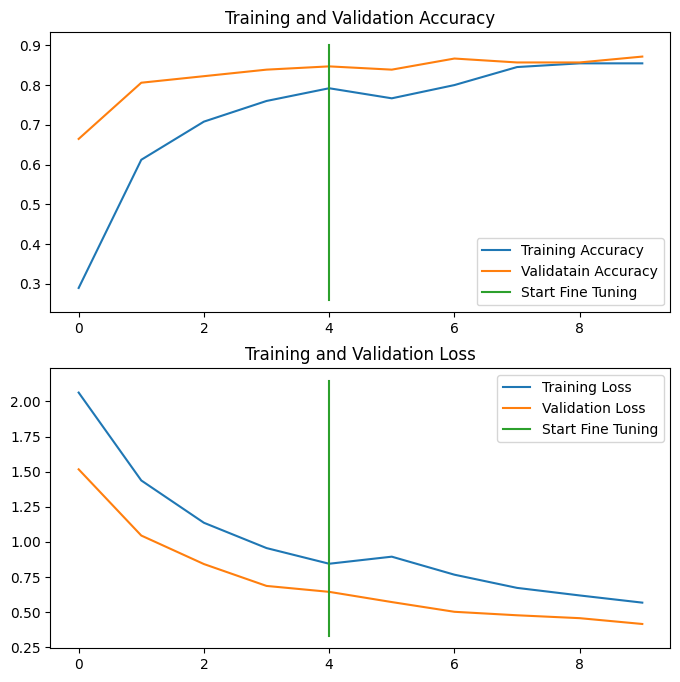

In [59]:
compare_history(model_two_history,history_fintuning)

## Model 4: Fine-tuning and existing model on all the data

In [60]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2025-04-23 17:41:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  21.3MB/s    in 23s     

2025-04-23 17:42:00 (21.4 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [61]:
from zipfile import ZipFile
with ZipFile('10_food_classes_all_data.zip', 'r') as myzip:
    myzip.extractall()

In [62]:
data_dir = "10_food_classes_all_data"
for dirpath,dirname,filenames in  os.walk(data_dir):
  print(f"There are {dirname} directories and {len(filenames)} images in '{dirpath}'.")

There are ['train', 'test'] directories and 0 images in '10_food_classes_all_data'.
There are ['pizza', 'chicken_wings', 'ramen', 'grilled_salmon', 'hamburger', 'ice_cream', 'sushi', 'steak', 'chicken_curry', 'fried_rice'] directories and 0 images in '10_food_classes_all_data/train'.
There are [] directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are [] directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are [] directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are [] directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are [] directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are [] directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are [] directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are [] directories and 750 images in '10_food_classes_all_data/train/steak'.
There are [] directories a

In [63]:
# dataset to load using the tf.keras.utils.image_dataset

BATCH_SIZE = 32
img_height = 224
img_width = 224
IMAGE_SIZE = (img_height,img_width)

train_data_dir = str(data_dir) + "/train"
test_data_dir =  str(data_dir) + "/test"

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  seed=123,
  # label_mode='categorical', for one_hot_encode
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  seed=123,
)



Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [64]:
model_two.evaluate(test_ds)
[0.49759194254875183, 0.843999981880188]

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8632 - loss: 0.4588


[0.49759194254875183, 0.843999981880188]

## To train a  fine_tuning model(model 4) we need to revert model_2 back to its feature extraction weights.


In [65]:
model_two.load_weights(checkpoint_filepath)
model_two.evaluate(test_ds)

 2/79 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8281 - loss: 0.6708 

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8388 - loss: 0.6603


[0.6750705242156982, 0.8339999914169312]

In [66]:
# check which layer are trainable
for i,layer in enumerate(model_two.layers):
    print(i,layer,layer.trainable)

0 <InputLayer name=input_layer_8, built=True> True
1 <Sequential name=data_augmentation, built=True> True
2 <Functional name=efficientnetb0, built=True> True
3 <GlobalAveragePooling2D name=global_average_pooling, built=True> True
4 <Dense name=dense_3, built=True> True


In [67]:
# check which of the layers of the base_model are traibale ?
for i,layer in enumerate(model_two.layers[2].layers[-10:]):
    print(i,layer.name,layer.trainable)

0 block7a_se_squeeze True
1 block7a_se_reshape True
2 block7a_se_reduce True
3 block7a_se_expand True
4 block7a_se_excite True
5 block7a_project_conv True
6 block7a_project_bn True
7 top_conv True
8 top_bn True
9 top_activation True


In [68]:
# becuase the weight are load we have to complile the model_two to update the weight to the load weight
learning_rate = 0.001/10
model_two.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # we used this loss function when our label are not in one_hot_encoded
    optimizer = tf.keras.optimizers.Adam(learning_rate), # adam optimizer learning_rate/10
    metrics = ['accuracy'] # accuracy to check the performance of the model on the traning and validataion dataset
)

In [69]:
7500/32

234.375

In [70]:
len(train_ds)

235

In [71]:
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

full_data_history_fintuning = model_two.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch = len(model_two_history.epoch),
    validation_data=test_ds,
    validation_steps=int(0.25 * len(test_ds)),
    callbacks=[create_tensorboard_callback(dir_name="model_logs", experiment_name="fine_tune_with_full_data")],

)


Saved tensorboard log files to model_logs/fine_tune_with_full_data/20250423-174222
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.7317 - loss: 0.9219 - val_accuracy: 0.8832 - val_loss: 0.3715
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.8000 - loss: 0.6407 - val_accuracy: 0.9095 - val_loss: 0.2843
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.8201 - loss: 0.5659 - val_accuracy: 0.9112 - val_loss: 0.2736
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.8393 - loss: 0.5126 - val_accuracy: 0.9128 - val_loss: 0.2587
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.8427 - loss: 0.4812 - val_accuracy: 0.9013 - val_loss: 0.2775


In [72]:
model_two.evaluate(test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9044 - loss: 0.2838


[0.2742995321750641, 0.9100000262260437]

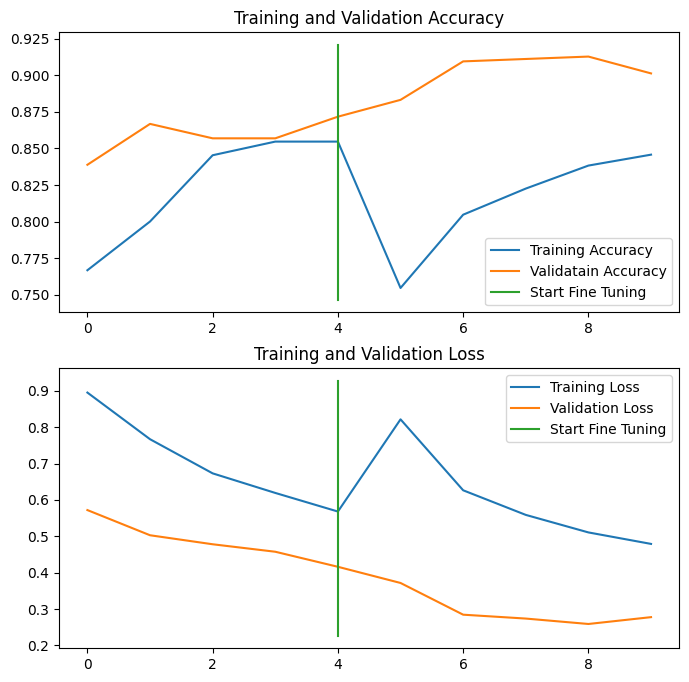

In [73]:
compare_history(history_fintuning,full_data_history_fintuning)

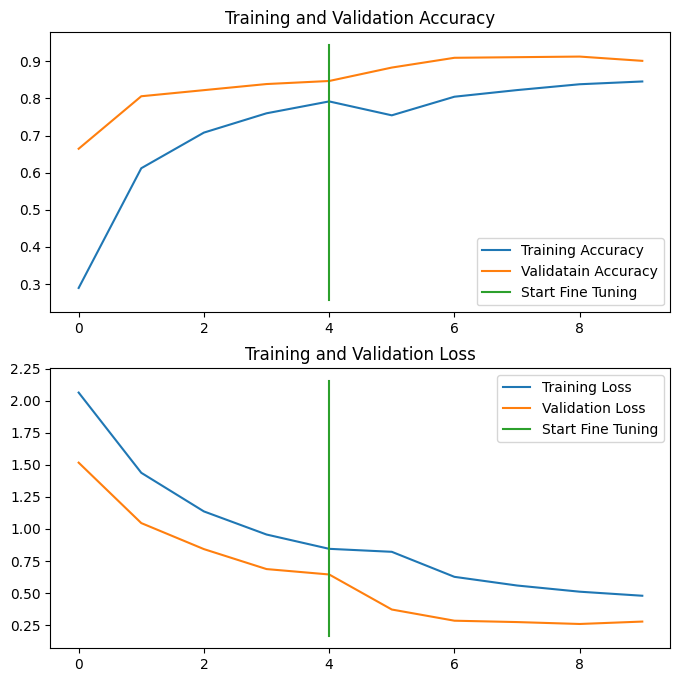

In [74]:
compare_history(model_two_history,full_data_history_fintuning)

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

%tensorboard --logdir=model_logs